# ITU-ML5G-PS-005-KDDI Task2

In [1]:
import gc
import numpy as np
import pandas as pd
from tools.preprocessing import Processor
from tools.generator import ReccurentTrainingGenerator, ReccurentTestGenerator

2022-11-22 06:49:29.153014: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 06:49:29.183695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 06:49:29.183711: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load data

In [2]:
train_0 = pd.read_csv('data/ML5G-PS-005_train_0.csv', index_col=0, header=0)
train_1 = pd.read_csv('data/ML5G-PS-005_train_1.csv', index_col=0, header=0)
train_2 = pd.read_csv('data/ML5G-PS-005_train_2.csv', index_col=0, header=0)
train_3 = pd.read_csv('data/ML5G-PS-005_train_3.csv', index_col=0, header=0)
train_4 = pd.read_csv('data/ML5G-PS-005_train_4.csv', index_col=0, header=0)
train_5 = pd.read_csv('data/ML5G-PS-005_train_5.csv', index_col=0, header=0)
train_data = pd.concat([train_0, train_1, train_2, train_3, train_4, train_5])
del train_0, train_1, train_2, train_3, train_4, train_5

test_0 = pd.read_csv('data/ML5G-PS-005_test_0.csv', index_col=0, header=0)
test_1 = pd.read_csv('data/ML5G-PS-005_test_1.csv', index_col=0, header=0)
test_2 = pd.read_csv('data/ML5G-PS-005_test_2.csv', index_col=0, header=0)
test_data = pd.concat([test_0, test_1, test_2])
del test_0, test_1, test_2
gc.collect()

0

In [3]:
preprocessor = Processor(train_data, test_data)

In [4]:
X, Y, test_X, test_Y = preprocessor.get_diff_data()
test_labels = preprocessor.test_label.values

# Train

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
timesteps = 15
delay = 45
batch_size = 64
input_dim = X.shape[-1]

In [7]:
input = Input(shape=(timesteps, input_dim))
lstm = LSTM(256, input_shape=(timesteps, input_dim), return_sequences=True)(input)
lstm = LSTM(256)(lstm)
dropout = Dropout(0.5)(lstm)
dense = Dense(1)(dropout)
model = Model(inputs=input, outputs=dense)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

2022-11-22 06:50:37.066014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 06:50:37.066282: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 06:50:37.066719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hakiitakeru-XPS-13-9305): /proc/driver/nvidia/version does not exist
2022-11-22 06:50:37.070569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 329)]         0         
                                                                 
 lstm (LSTM)                 (None, 15, 256)           600064    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,125,633
Trainable params: 1,125,633
Non-trainable params: 0
_________________________________________________________________


In [8]:
train_X = X[:500*70]
train_Y = Y[:500*70]
val_X = X[500*70:]
val_Y = Y[500*70:]

In [9]:
train_generator = ReccurentTrainingGenerator(train_X, train_Y, batch_size, timesteps, delay)
val_generator = ReccurentTrainingGenerator(val_X, val_Y, batch_size, timesteps, delay)

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [11]:
history = model.fit(x=train_generator, epochs=20, verbose=1, callbacks=callback, validation_data=val_generator)

Epoch 1/20
79/79 [==============================] - 6s 51ms/step - loss: 0.0091 - val_loss: 0.0023
Epoch 2/20
79/79 [==============================] - 4s 45ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 3/20
79/79 [==============================] - 4s 46ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/20
79/79 [==============================] - 4s 45ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 5/20
79/79 [==============================] - 4s 47ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/20
79/79 [==============================] - 4s 45ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/20
79/79 [==============================] - 3s 44ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 8/20
79/79 [==============================] - 3s 43ms/step - loss: 0.0022 - val_loss: 0.0019


# Evaluation

In [12]:
from tools.metrics import Evaluation

In [13]:
test_generator = ReccurentTestGenerator(test_X, batch_size, timesteps, delay)

In [14]:
pred = model.predict(test_generator)
pred = pred.reshape(300, -1)

47/47 [==============================] - 1s 17ms/step


In [15]:
test_Y = test_Y.values.reshape(300, -1)

In [16]:
evaluation = Evaluation(pred, test_Y, test_labels, timesteps, delay, threshold=0.3)

In [17]:
evaluation.MSE()

0.00234081218139981

In [18]:
evaluation.score()

[[225   0]
 [  3  72]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       225
           1       1.00      0.96      0.98        75

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



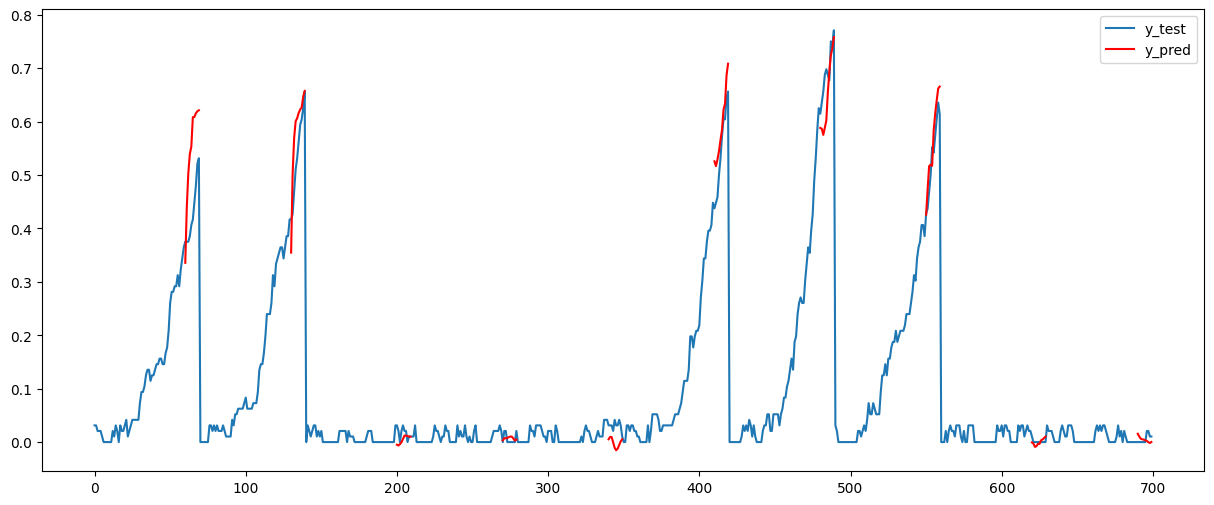

In [19]:
evaluation.visualization()